## Ultimate Data Science Challenge

This notebook contains my solution to Ultimate Data Science Challenge. Details of various tasks are divided as follows.
1. Exploratory data analysis of simulated data
2. Given a scenario, design statistical experiment,assumptions and statistical tests. Also state the caevets in your method.
3. Employ end-to-end data science workflow on the given dataset.

More details about the task can be found near the respective task sections.

In [1]:
## Importing Required libraries

import pandas as pd
import numpy as np
import json

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.rcParams["figure.figsize"] = (15,9)

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
## Center aliging outputs (plots)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them

"logins.json" file contains (simulated) timestamps of user logins in a particular geographic location

In [3]:
# Loading the data
logins = pd.read_json('logins.json')
logins.info()
logins.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


> As see from the loaded data, the data contains one column which contains login time stamps. We do some data pre-processing to aggregate login count based on 15 min interval.

In [4]:
# Set the login time as data index
logins = logins.set_index('login_time').sort_index()
logins['count'] = 1
logins.head(10)

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1
1970-01-01 20:21:41,1
1970-01-01 20:26:05,1
1970-01-01 20:26:21,1
1970-01-01 20:31:03,1


### Trend of login aggreagted over 15 min

In [5]:
## Resampling the data 
df_min15 = logins.resample('15T').count()
df_min15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


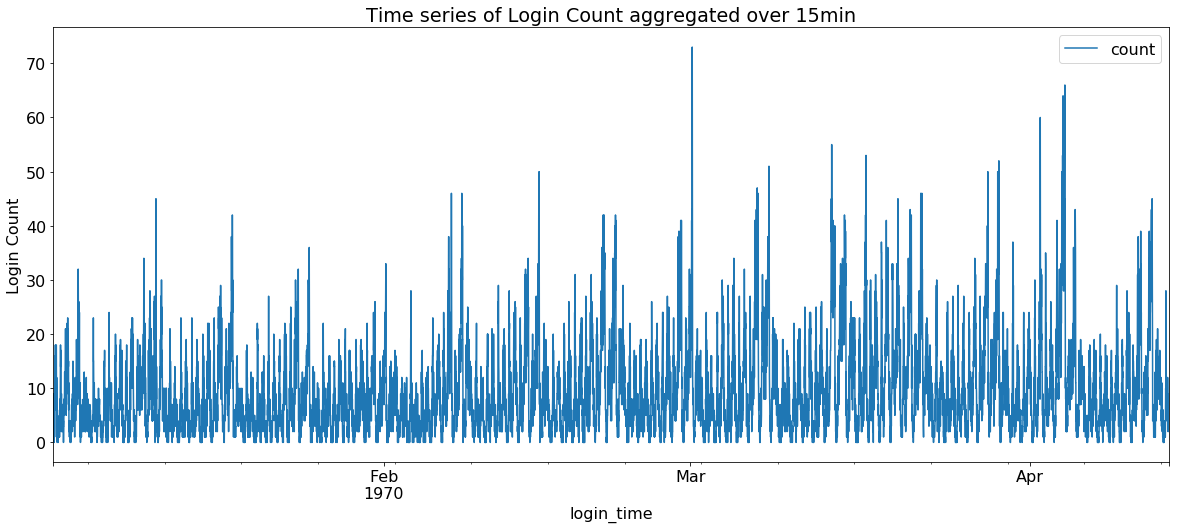

In [6]:
## Visualizing the trend of login count aggregated over 15 min bucket
df_min15.plot(figsize=(20,8))
plt.ylabel("Login Count")
plt.title("Time series of Login Count aggregated over 15min")
plt.show()

> We see that there seems to be some periodicity however, its hard to draw any conclusions. Let's visualize the same plot with fewer data points to eye ball trend if any

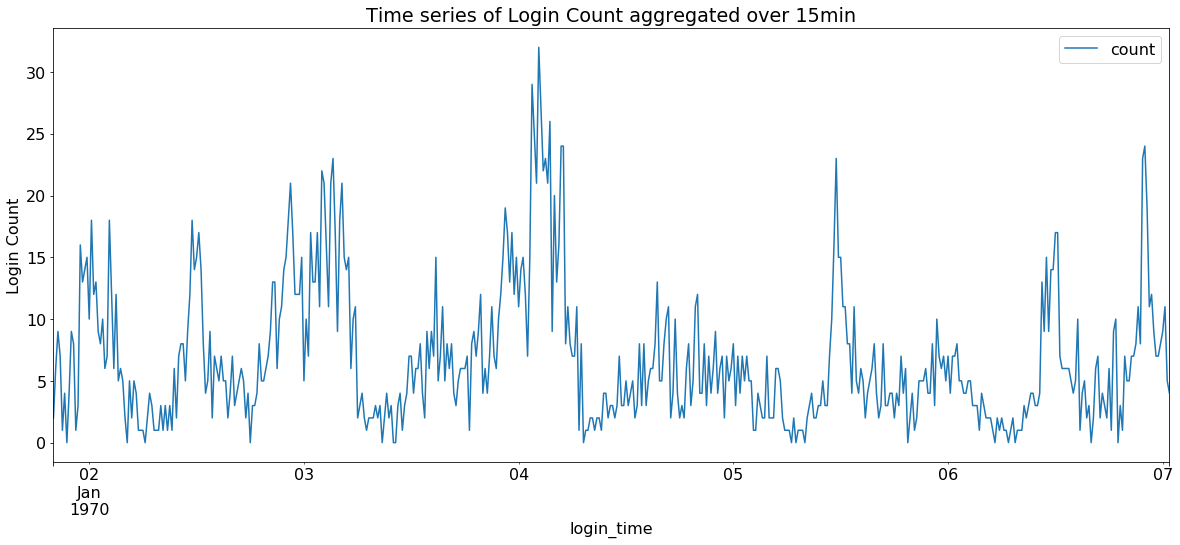

In [7]:
## Ploting using fewer observation
df_min15[0:500].plot(figsize=(20,8))
plt.ylabel("Login Count")
plt.title("Time series of Login Count aggregated over 15min")
plt.show()

> Now we can clearly see that, the login count has some sort of periodicity as it changes over different hours in a day. Plot of entire data shows high peaks with time. Let's get statistical number of login count

In [8]:
## Statisitcs of login count
df_min15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


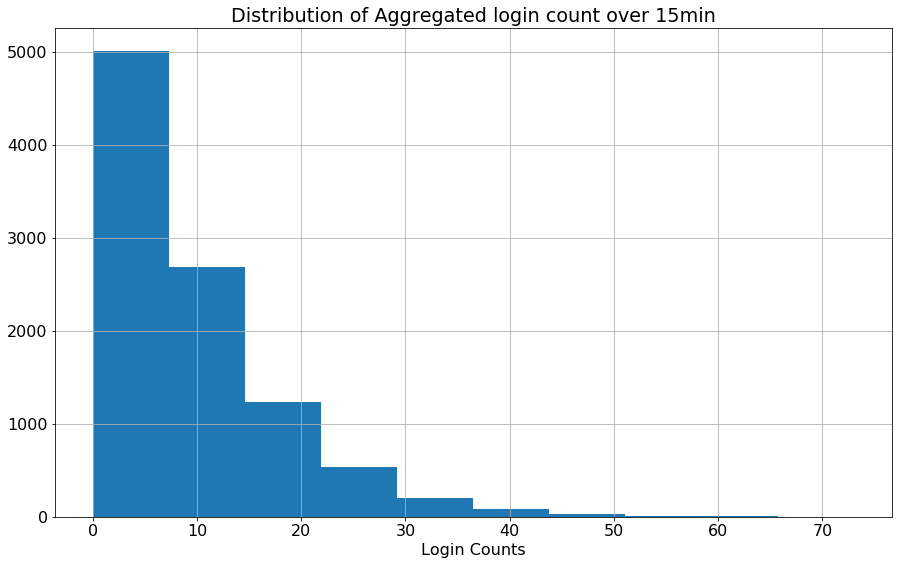

In [9]:
## Histogram of login count
df_min15.hist()
plt.title("Distribution of Aggregated login count over 15min")
plt.xlabel("Login Counts")
plt.show()

> From the statistics, we see the mean login count aggregated over 15 min is 7 times i.e., on average we see 7 logins in every 15 mins. The hsitogram shows the data is right skewed with few obseravtion with much higher login counts. Also, it showed be noted that the standard deviation is approx 8 which implies that the login count has higher variance. Now, lets see how the login counts vary across different days of a week to get better understanding of higher variance

In [10]:
## mapping days to week 
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
logins['weekday'] = logins.index.weekday
logins['weekname']  =logins['weekday'].map(dayOfWeek)
logins.head()

,count,weekday,weekname
login_time,,,
1970-01-01 20:12:16,1,3,Thursday
1970-01-01 20:13:18,1,3,Thursday
1970-01-01 20:16:10,1,3,Thursday
1970-01-01 20:16:36,1,3,Thursday
1970-01-01 20:16:37,1,3,Thursday


In [11]:
logins['weekname'] = pd.Categorical(logins['weekname'], 
                                   categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], 
                                   ordered=True)

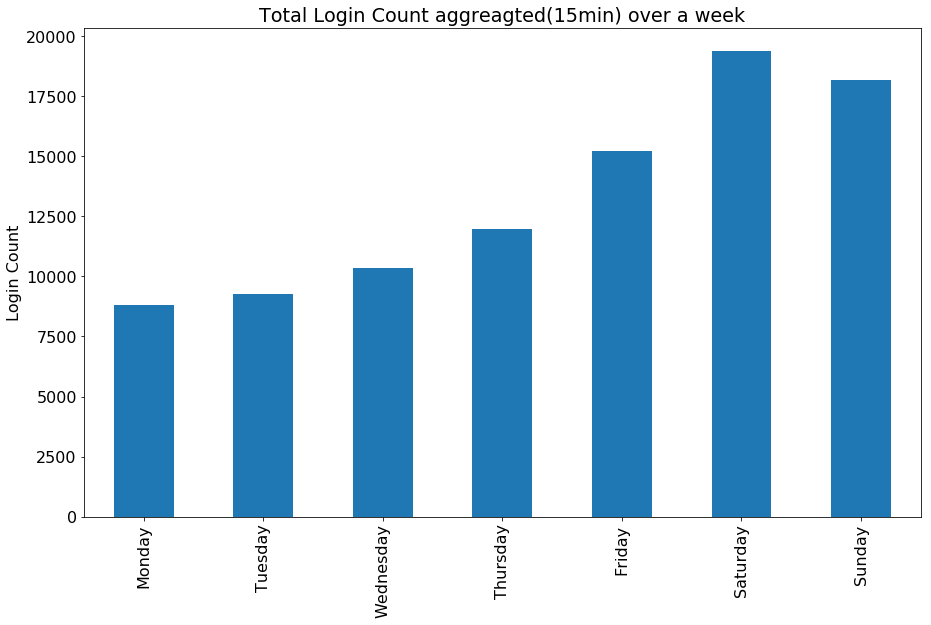

In [12]:
weekday_counts = logins.groupby('weekname')['count'].aggregate(sum)
weekday_counts.plot(kind = 'bar')
plt.ylabel('Login Count')
plt.xlabel('')
plt.title("Total Login Count aggreagted(15min) over a week")
plt.show()

> Above graphs speaks for itself. We see login count increase over weekend nearly twice the login counts on monday. Lets, see the statistics of login counts over different days in a week.

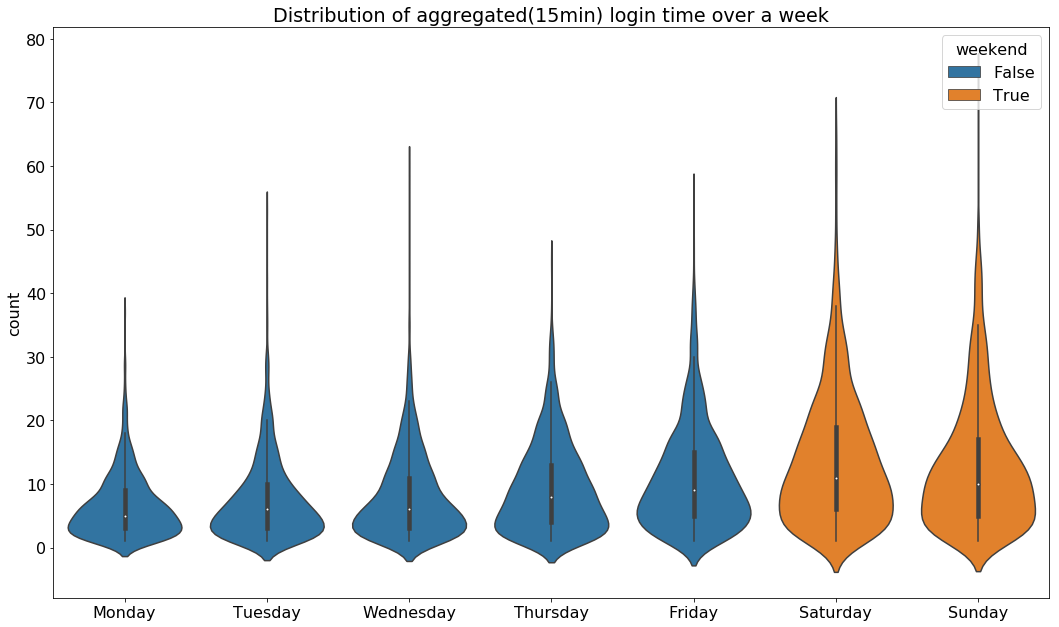

In [13]:
## plotting distribution 
box = pd.DataFrame()
for i in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']:
    x = logins[logins.weekname == i].\
    drop(labels = ['weekday'], axis = 1).\
    resample('15T').sum().reset_index()
    
    x['weekday']= i
    box = box.append(x, ignore_index=True)

box["weekend"] = box["weekday"].isin(["Saturday", "Sunday"])
sns.violinplot(x="weekday", y="count", hue="weekend", data=box, dodge=False)
plt.xlabel('')
plt.title('Distribution of aggregated(15min) login time over a week')
plt.tight_layout()

> We see that compared to the weekdays login count distribution, weekend distribution is wide spread. Login count distribution over the week is right skewed. Now that we explored login count distribution over days and over a week. Lets explore distribution in a day

In [14]:
## Getting the hourly data over days in a week
hour_login = logins.drop(['weekday'], axis =1).resample('H').sum()


hour_login['hour'] = hour_login.index.hour
hour_login['weekday'] = hour_login.index.weekday
hour_login['weekname']  =hour_login['weekday'].map(dayOfWeek)

hour_login['weekname'] = pd.Categorical(hour_login['weekname'], 
                                   categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], 
                                   ordered=True)
hour_login.head()

,count,hour,weekday,weekname
login_time,,,,
1970-01-01 20:00:00,24.0,20,3,Thursday
1970-01-01 21:00:00,9.0,21,3,Thursday
1970-01-01 22:00:00,21.0,22,3,Thursday
1970-01-01 23:00:00,58.0,23,3,Thursday
1970-01-02 00:00:00,53.0,0,4,Friday


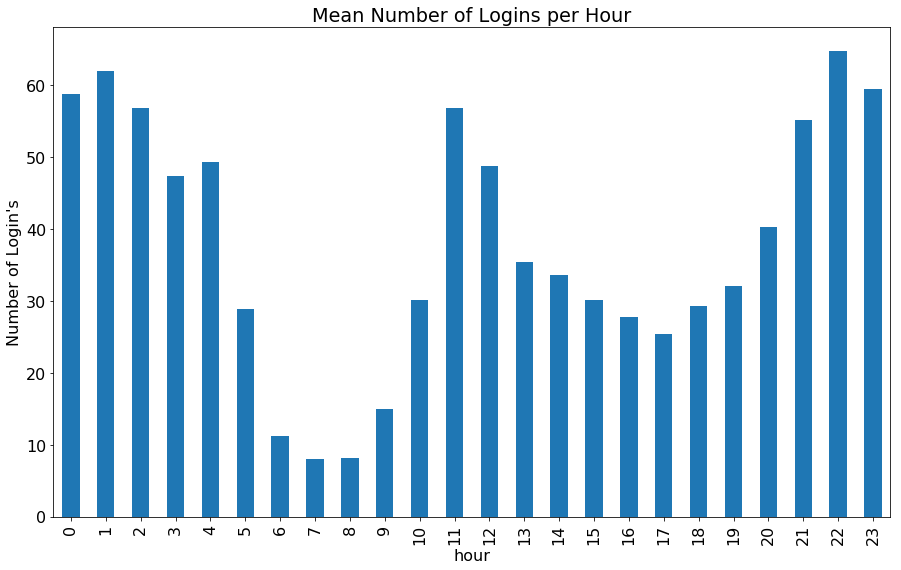

In [15]:
## Mean number of logins in a day
hour_login.groupby(['hour']).mean().drop(labels='weekday',axis =1).plot(kind='bar', legend = False)
plt.ylabel("Number of Login's")
plt.title('Mean Number of Logins per Hour')
plt.show()

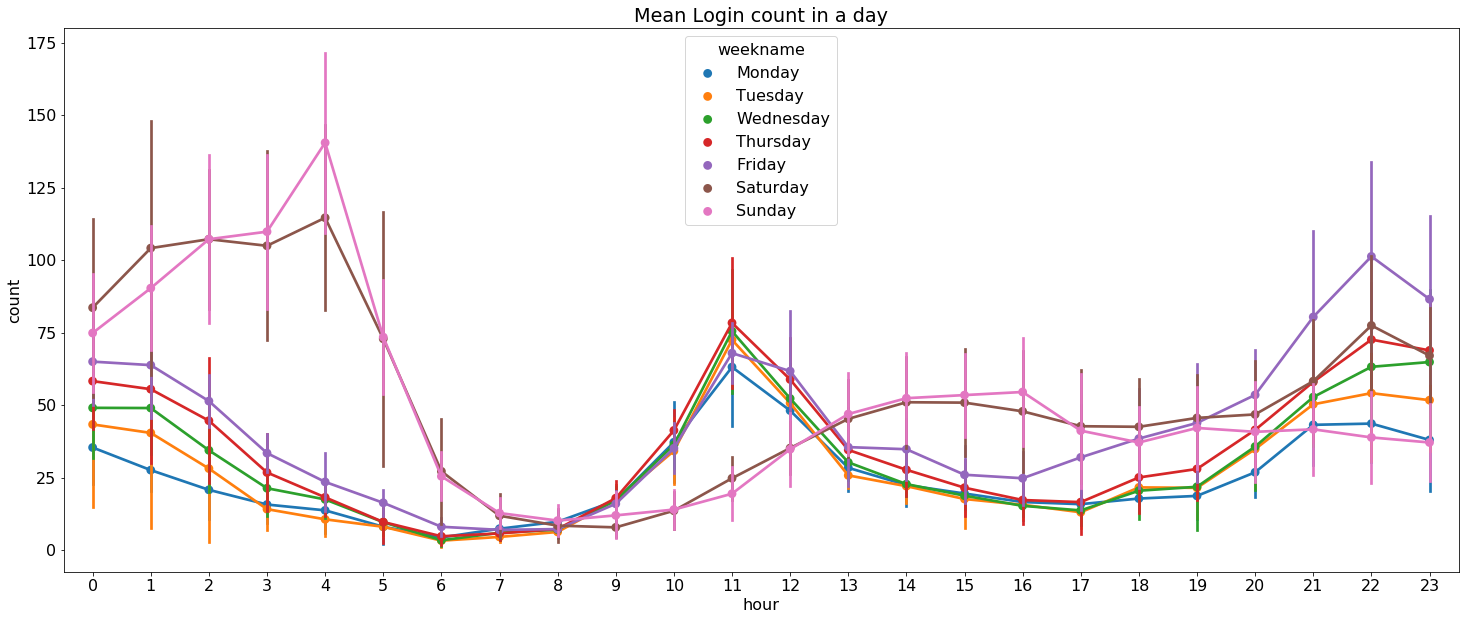

In [16]:
## Plotting mean login count in a day
sns.pointplot(x='hour',y='count', hue='weekname', data=hour_login,ci="sd")
plt.gcf().set_size_inches(25,10)
plt.title('Mean Login count in a day')
plt.show()

> Above plots shows mean login count in a day,we notice mean login count early in the morning seems to increase over the week starting from monday. However, as the day start on weekdays the mean login time on all days in a week seem to increase to same mean value at around 11 while on weekends we see that there is dip in login count at 11. On weekends, most login counts are recorded early in the morning some reasons might include people going to restaurants, late night clubs etc on weekends 


### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

> Key Measure of Success: Mean driver's activity in the other city i.e., we will calcualte the mean of number of times driver who is exclusive to a city drove in the other city. It is safe to assume that we have the data to calculate number of times driver drove in both cites. It is stated that drivers are exclusive to a city thus the mean difference of times the driver drove in both cities would be huge. Thus, if we can show statistical significance of mean difference of time between driver's activity who is exclusive to a city and his activity in the other city we can infer that the change had a effect on the drivers activity.

#### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
    i.   how you will implement the experiment    
    ii.  what statistical test(s) you will conduct to verify the significance of the observation   
    iii. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

> Assuming the drivers activity is monitored in both cities, we have to choose time period or the amount of data we would take into analysis. The time can be decided based on the volume of the data or companies management policies. I would recommended atleast a month of data as I believe it would be sufficient time for drivers to get used and follow the new regualtions. We will use the data gathered up untill today as control data i.e., activity of drivers in both cities. We will inform the driver partners about the new change in operations. Assuming this would take a week, we will start monitoring the data after the week as test data for atleast a month.

> Now that we have data, we will conduct one-tailed t-test. The reason for choosing this test is
1. We are interested only is positive mean difference of times driver drove is other city before the policy and after the policy. So the test has to be one tailed.
2. We do not have population standard deviation so we choose t-test over Z-test

> Null Hypothesis: There is no effect of paying for toll by Ultimate on drivers activity in the other city  
  Alternate Hypothesis: There is effect of paying for toll by Ultimate on drivers activity in the other city

> We choose p-value of 0.05 for the experiment (Our according to the companies policies). Any p-value greater than 0.05 renders the Null hypothesis to be true.

> Some of the cavets:
1. It is assumed that only toll is responsible for drivers activity to be exclusive to the city
2. During data collection phase, we should be vigilant of any activites in either of cities that could potentially make drivers drive in other cities then often. These events can include football games, concert, summer fest etc.
3. In the experiment, we do not differentiate between drivers of each city. For example, after the toll only driver of Gotham city are driving more in the other city or vice versa. We need to perform one-tailed t-test for both cities individually
4. We should remember that our experiment does not take into account of weekdays or weekends. This could potentially make a difference if the control period and test period data have different weekday and weekend distribution.
5. Finally, even if the experiment outcome shows paying toll by Ultimate increase drivers activity, it should be noted that revenue after the implementation of toll has to be examined.


## Part 3 Predictive modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?     
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.        
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

### Data description   

1. city: city this user signed up in
2. phone: primary device for this user
3. signup_date: date of account registration; in the form ‘YYYYMMDD’
4. last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
5. avg_dist: the average distance in miles per trip taken in the first 30 days after signup
6. avg_rating_by_driver: the rider’s average rating over all of their trips
7. avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
8. surge_pct: the percent of trips taken with surge multiplier > 1
9. avg_surge: The average surge multiplier over all of this user’s trips
10. trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
11. ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
12. weekday_pct: the percent of the user’s trips occurring during a weekday

In [17]:
## Loading the JSON file
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

## Converting the loaded file as pandas dataframe
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [18]:
print("Number of Observations in the data: ", df.shape[0])
print("Number of features/columns in the data: ", df.shape[1])

Number of Observations in the data:  50000
Number of features/columns in the data:  12


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [20]:
## Parsing the data timestamp in the data to datatime data type as they are currently read as object
for i in ['signup_date','last_trip_date']:
    df[i] = pd.to_datetime(df[i])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


> We see that they are missing values in columns: avg_rating_by_driver, avg_rating_of_driver, phone. We see there are no missing values in the signup_date and last_trip_date.Hence, we can use those columns to find the retention rate as described earlier. We will deal with missing later in the notebook

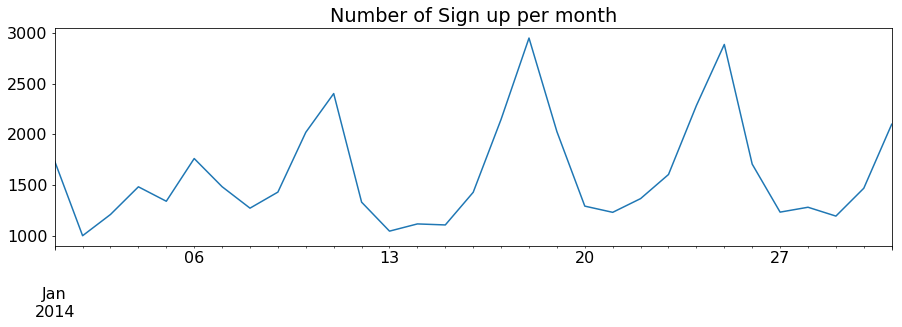

In [21]:
## Visualzing time series of sign up 
df.groupby('signup_date').size().plot(figsize = (15,4))
plt.title('Number of Sign up per month')
plt.xlabel('')
plt.show()

> we see all the signup are done in the month of Jan with sign up increase with time.

In [22]:
## Findig the active users
"""
Active Users: A user is retained if they were “active” (i.e. took a trip) in the preceding 30 days
"""
active_user = []

## Looping over each observation to get date start date and end date. To the start date 
for i in range(len(df)):
    start_date = df['signup_date'][i]
    end_date = start_date + pd.Timedelta('181D') 
    active_date = end_date - pd.Timedelta('30D') 
    if active_date <= pd.Timestamp(df['last_trip_date'][i]) <= end_date:
        active_user.append("Active") 
    else:
        active_user.append("Not Active")

active_user = pd.Series(active_user)
df['active_user'] = active_user.values   

In [23]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,Not Active
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,Not Active
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,Not Active
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,Active
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,Not Active


In [24]:
## percentage of people retained/active
print(df['active_user'].value_counts(normalize = True)*100)
print(50*'-')
print(50*'-')
print("Percentage of Active users/retained: {:.3f}%.".format(100*(df['active_user'] == 'Active').sum()/len(df)))

Not Active    75.604
Active        24.396
Name: active_user, dtype: float64
--------------------------------------------------
--------------------------------------------------
Percentage of Active users/retained: 24.396%.


In [25]:
## NUll Values
(100*df.isnull().sum().sort_values(ascending = False)/len(df))

avg_rating_of_driver      16.244
phone                      0.792
avg_rating_by_driver       0.402
active_user                0.000
weekday_pct                0.000
ultimate_black_user        0.000
trips_in_first_30_days     0.000
surge_pct                  0.000
signup_date                0.000
last_trip_date             0.000
city                       0.000
avg_surge                  0.000
avg_dist                   0.000
dtype: float64

We see that, average rating of driver columns has approx 16% missing values. we will understand the distribution of the rating and decide what's the best way to treat the missing values

In [26]:
print(df.avg_rating_of_driver.describe())

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64


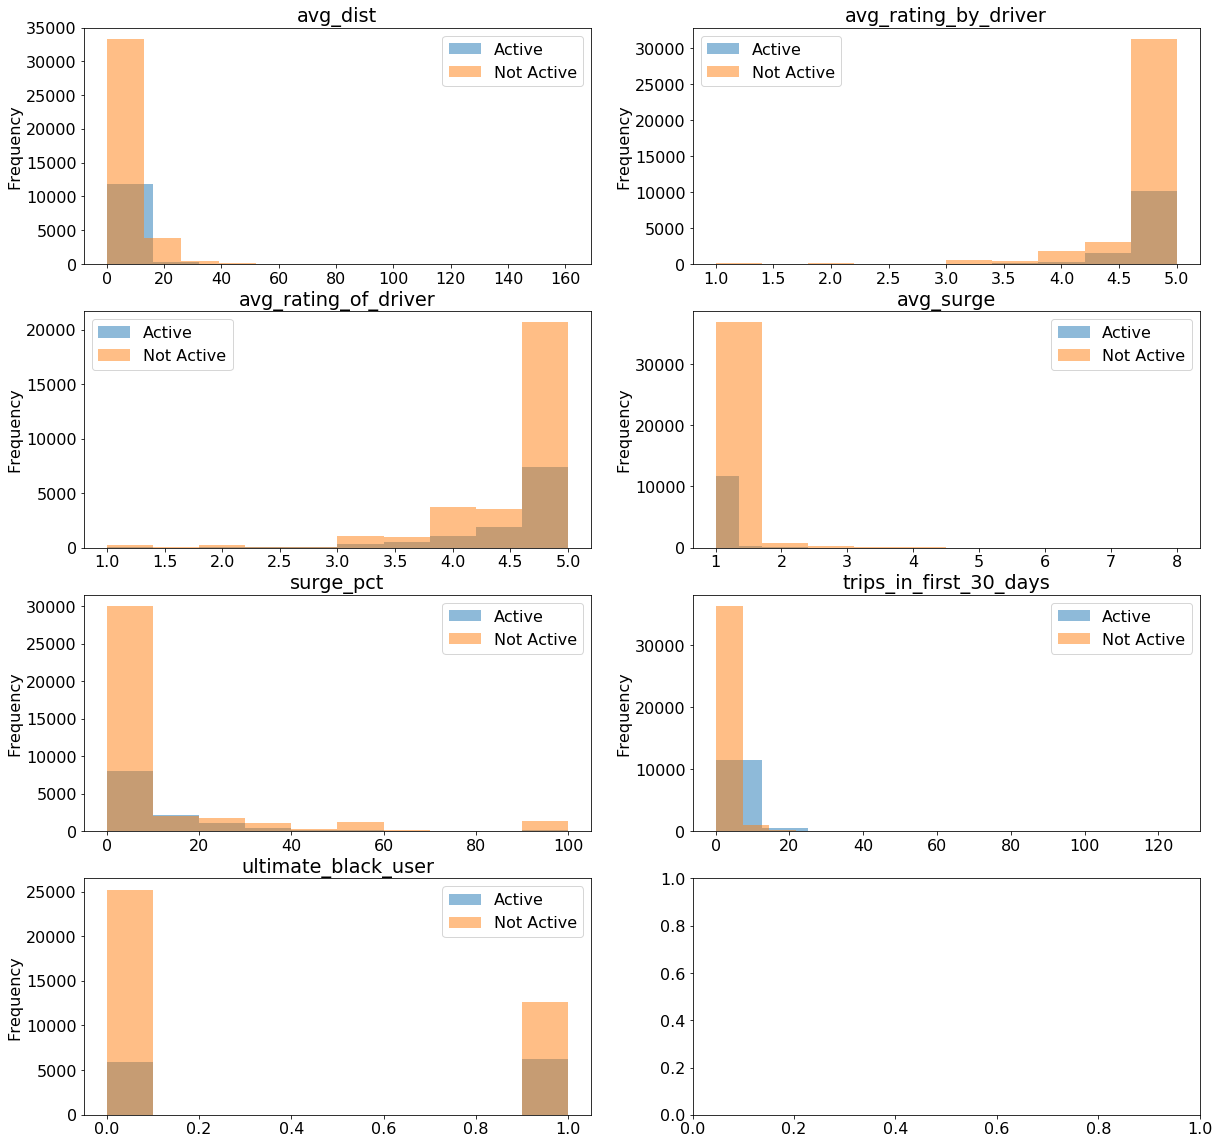

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(20,20))


i = 1
for columns in df.select_dtypes(include =["float64","int64","bool"]):
    plt.subplot(4,2,i)
    df.groupby('active_user')[columns].plot(kind='hist', alpha =.5, title = columns,legend=True)

    #sns.violinplot(x= df[columns],data=df)
    i += 1 
    if i == 8:
        break
  
plt.show()

In [28]:
for column in df.select_dtypes(include =["float64","int64"]):
    df[column] = df[column].fillna(df[column].median())

print(df.isnull().sum())
print(100*'-')
print('')
df.dropna(axis=0,inplace=True)
print("Dimensions of the data after imputation: ")
print(50*'-')
df.shape

avg_dist                    0
avg_rating_by_driver        0
avg_rating_of_driver        0
avg_surge                   0
city                        0
last_trip_date              0
phone                     396
signup_date                 0
surge_pct                   0
trips_in_first_30_days      0
ultimate_black_user         0
weekday_pct                 0
active_user                 0
dtype: int64
----------------------------------------------------------------------------------------------------

Dimensions of the data after imputation: 
--------------------------------------------------


(49604, 13)

In [29]:
df.groupby('active_user').phone.value_counts(normalize=True)*100

active_user  phone  
Active       iPhone     84.101040
             Android    15.898960
Not Active   iPhone     65.068018
             Android    34.931982
Name: phone, dtype: float64

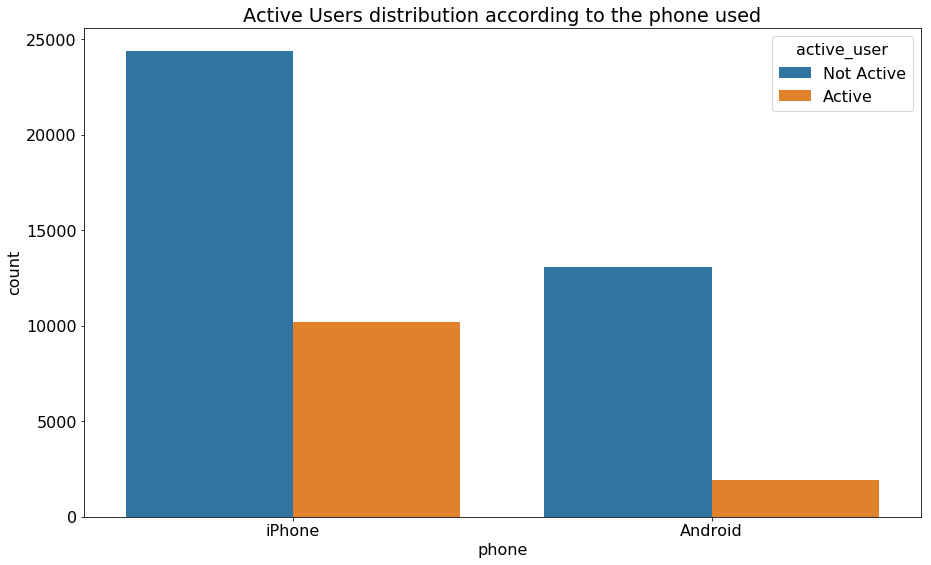

In [30]:
sns.countplot(hue="active_user", x="phone", data=df)
plt.title("Active Users distribution according to the phone used")
plt.show()

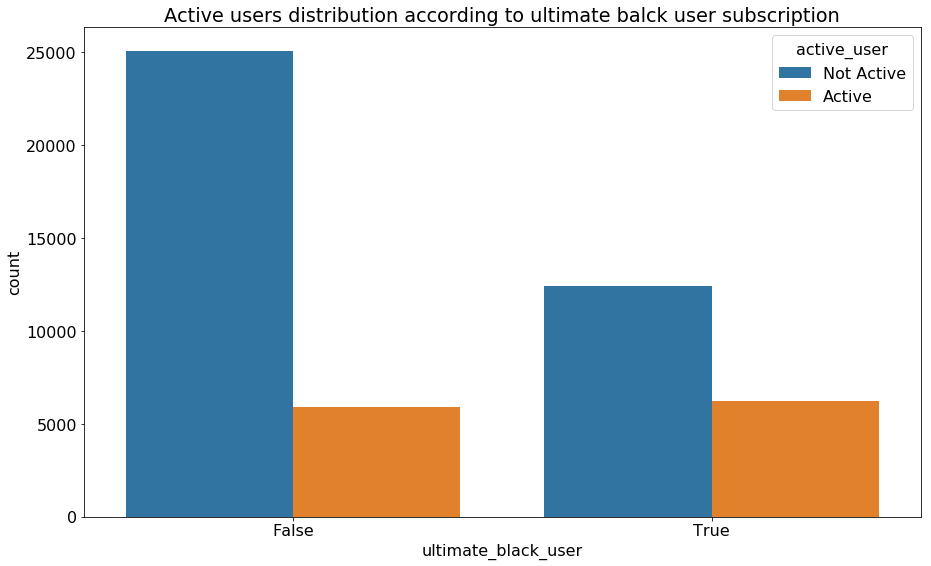

In [31]:
sns.countplot(hue="active_user", x="ultimate_black_user", data=df)
plt.title("Active users distribution according to ultimate balck user subscription")
plt.show()

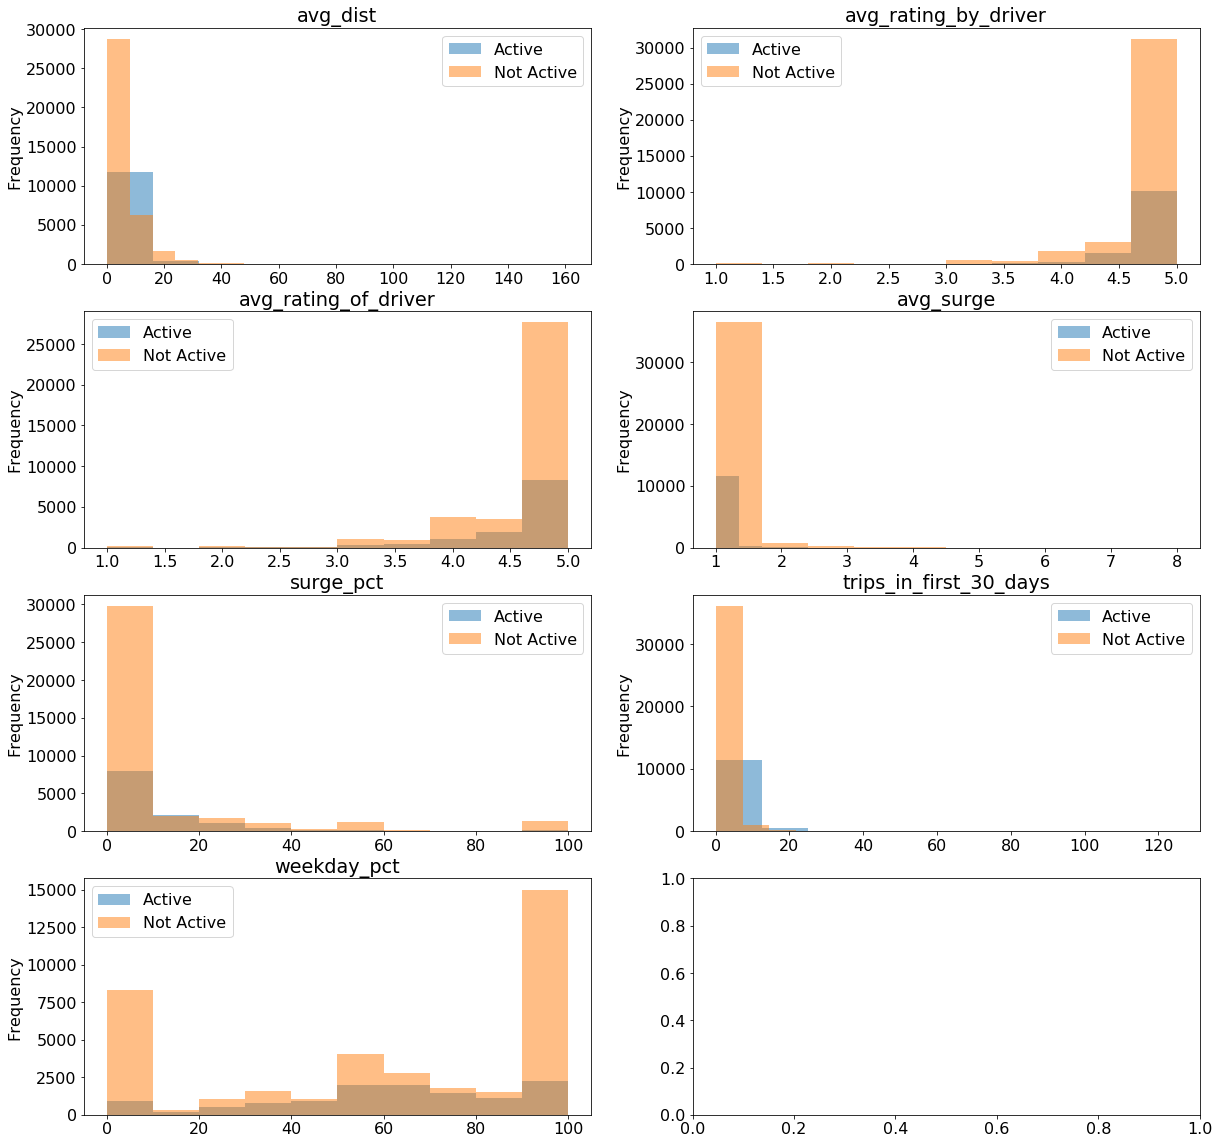

In [32]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))


i = 1
for columns in df.select_dtypes(include =["float64","int64"]):
    plt.subplot(4,2,i)
    df.groupby('active_user')[columns].plot(kind='hist', alpha =.5, title = columns, legend = True)
    #sns.violinplot(x= df[columns],data=df)
    i += 1 

plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
active_user               49604 non-null object
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(3)
memory usage: 6.2+ MB


In [34]:
## Dropping time columns
df.drop(["last_trip_date",'signup_date'],axis=1,inplace=True)

## Getting the prediction column: Active User
target = df.pop('active_user')

In [35]:
df = pd.get_dummies(df,drop_first=True)
df.ultimate_black_user = df.ultimate_black_user.astype(int)
df.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

In [36]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,1,0


In [37]:
target = target.map({'Active':1,'Not Active':0})

print("Percenatge distribution of target/dependent variable: \n",target.value_counts(normalize=True)*100 )

Percenatge distribution of target/dependent variable: 
 0    75.578582
1    24.421418
Name: active_user, dtype: float64


Now that we pre-processed the data for machine learning model. For sake of understanding our model better, we will train random forest classifer. 

In [38]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Scikit Learn Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score


We saw target/variable distribution is approx 1:4. When spliting the data into train and set, they might scenario where either training or test data can have very imbalanced i.e, for example training data can have target variable distribution of 1:8 and that would result in not poor model. So, we will employ stratified split of data to maintain target distribution in the even after spliting 

In [39]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state=123, stratify=target)


In [40]:
print("After stratification distribution of traget variables in train and test data \n"+ 100*'-' + '\n' + "Training")
print(y_train.value_counts(normalize=True)*100)
print("Test Data")
y_test.value_counts(normalize=True)*100


After stratification distribution of traget variables in train and test data 
----------------------------------------------------------------------------------------------------
Training
0    75.578963
1    24.421037
Name: active_user, dtype: float64
Test Data


0    75.577059
1    24.422941
Name: active_user, dtype: float64

In [41]:
## Cross Validation
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## Metric for model evaluation: Area Under the Receiver Operating Characteristic curve. 
model_metric  = make_scorer(roc_auc_score, greater_is_better=True)

In [42]:
#Initilizing Random Forest Classifier
RF = RandomForestClassifier(criterion='gini',n_jobs=-1)

## Defining Hyperparamter grid and gridsearch
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10], 'class_weight' : [None,'balanced',{0:1,1:2},{0:1,1:3}]}

RF_CV = GridSearchCV(RF, param_grid, cv=CV, scoring=model_metric, verbose=1)

In [43]:
## Fitting the data to RF classifier
RF_CV.fit(X_train, y_train)

#Print out the best model
print("Best parameters learned: ",RF_CV.best_params_)
print("AUROC score with best RF paramters",RF_CV.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  7.9min finished


Best parameters learned:  {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 40}
AUROC score with best RF paramters 0.742114946905


In [44]:
### Initialzing RandomForest Classifier with best parameters learned from Gridsearch

RF_best_param = RandomForestClassifier(criterion='gini', class_weight= RF_CV.best_params_['class_weight'], n_jobs=-1, 
                                       min_samples_split=RF_CV.best_params_['min_samples_split'], 
                                       max_depth=RF_CV.best_params_['max_depth'],
                                      n_estimators=RF_CV.best_params_['n_estimators'],)

## Fitting the model
RF_best_param.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [45]:
## Plotting AUROC scores to evaluate the model

## Code extracted from scikit learn: 
## http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import numpy as np
from sklearn.model_selection import learning_curve



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

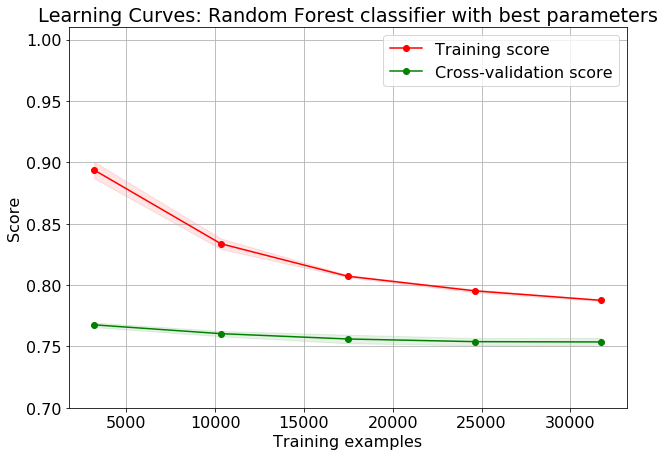

In [46]:
X, y = X_train, y_train


title = "Learning Curves: Random Forest classifier with best parameters"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

plot_learning_curve(RF_best_param, title, X, y, ylim=(0.7, 1.01), cv=CV, n_jobs=-1)
plt.gcf().set_size_inches(10,7)

plt.show()

In [47]:
## Prediction TEST SET

from sklearn.model_selection import cross_val_score
y_pred_prob = RF_best_param.predict_proba(X_test)[:,1]
print("AUROC score", roc_auc_score(y_test, y_pred_prob))
cv_auc = cross_val_score(RF_best_param, X, y, cv = CV,scoring = model_metric)
print("AUCROC score using 5-fold CV:  ",format(cv_auc))

AUROC score 0.817160927878
AUCROC score using 5-fold CV:   [ 0.74261083  0.7424114   0.73670782  0.73707662  0.74496427]


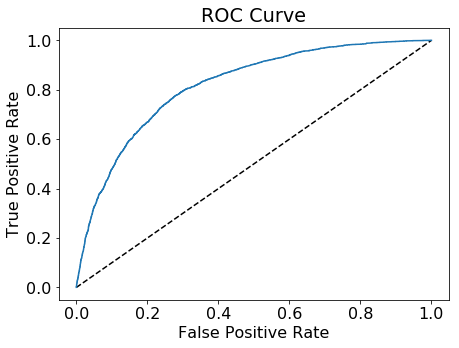

In [48]:
## Plotting ROC CURVE
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = RF_best_param.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plotting ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.gcf().set_size_inches(7,5)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
## Getting feature importance from classifier
feature_importances = pd.DataFrame(RF_best_param.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(11)

,importance
avg_rating_by_driver,0.194727
surge_pct,0.164299
weekday_pct,0.131016
avg_surge,0.103788
city_King's Landing,0.095706
avg_dist,0.077928
phone_iPhone,0.071702
trips_in_first_30_days,0.062003
avg_rating_of_driver,0.047674
ultimate_black_user,0.038693


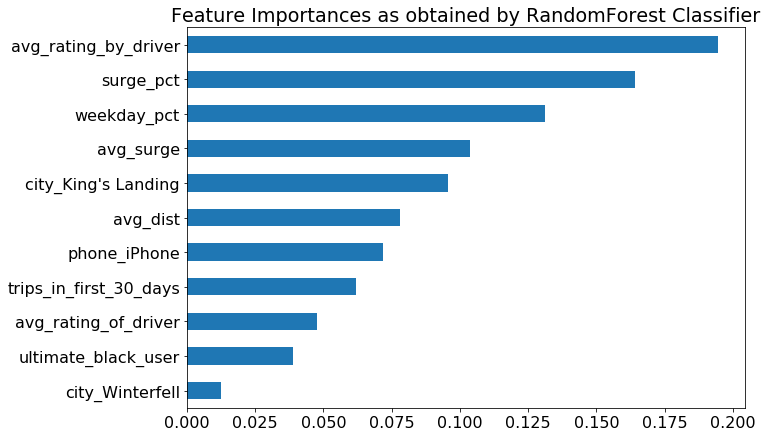

In [50]:
feature_importances.sort_values('importance', ascending=True).plot(kind = 'barh',legend=False)
plt.title("Feature Importances as obtained by RandomForest Classifier")
plt.gcf().set_size_inches(10,7)

[Feature importance variable explained](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)

The usual way to compute the feature importance values of a single tree is as follows:

you initialize an array feature_importances of all zeros with size n_features.

you traverse the tree: for each internal node that splits on feature i you compute the error reduction of that node multiplied by the number of samples that were routed to the node and add this quantity to feature_importances[i].

The error reduction depends on the impurity criterion that you use (e.g. Gini, Entropy, MSE, ...). Its the impurity of the set of examples that gets routed to the internal node minus the sum of the impurities of the two partitions created by the split.

Its important that these values are relative to a specific dataset (both error reduction and the number of samples are dataset specific) thus these values cannot be compared between different datasets

### Summary

In this notebook, we showcased the data science workflow abeit the deployment with little explanation as to why certain things are done. First we analysed, simualted data of login count of users. We drew some interesting stats such as when in a day login counts are high and login count distribution over days and weeks. In part 2, given a scenario, we are asked to set up experiment and necessary statistical measures to prove our hypothesis. In part 3, We are tasked to build a predictive model to predict keys features for rider retention. We started this task with data preprocessing, followed by exploratory data and training a machine learning model. We used RandomForest classifier for better understanding of trained model. Model has AUROC of approx 0.74 on test data which isn't great however, we shoudl remember that we didn't opt for more accruate model such as XGBoost, SVM etc., Finally, we plotted important features necessary for model prediction.


References:
1. https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined


### Experimental code: Ignore


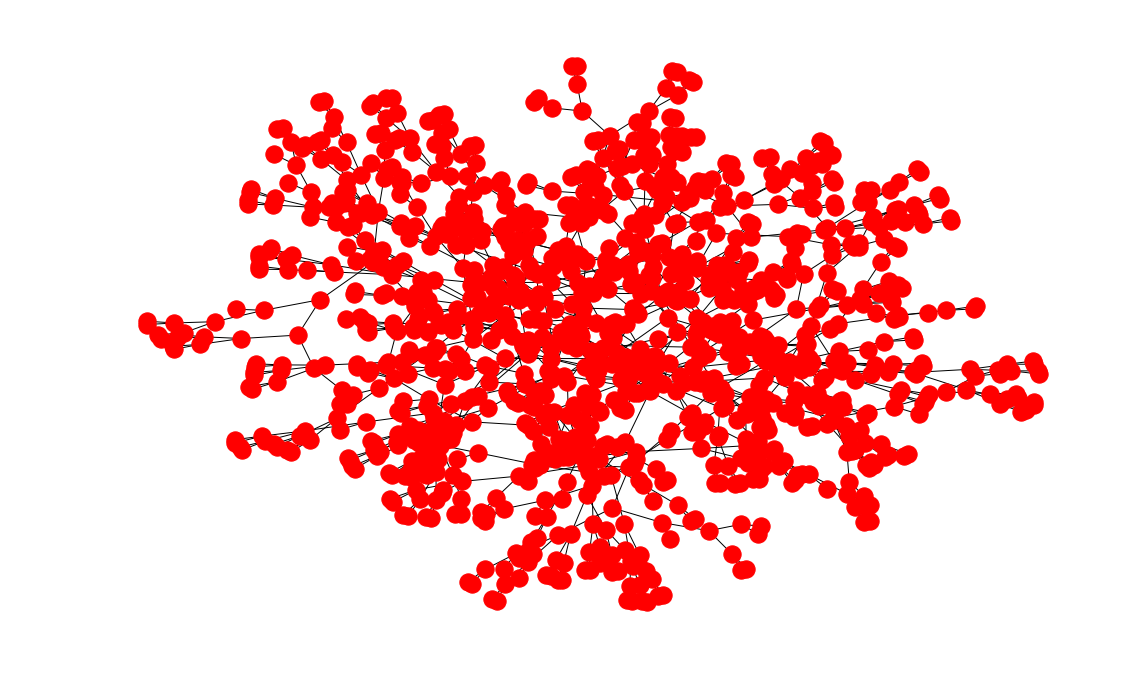

In [51]:
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
Gtmp = pgv.AGraph('tree.dot')
G = nx.Graph(Gtmp)
nx.draw(G)
plt.show()